     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.2/626.2 kB 42.8 MB/s eta 0:00:00
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.11.15
    Uninstalling aiohttp-3.11.15:
      Successfully uninstalled aiohttp-3.11.15
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0682
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0056
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0025
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0019
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0018
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0017
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0017
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0018
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0019
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0014
Epoch 13/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0017
Epoch 14/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0016
Epoch 15/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0015
Epoch 16/50
24/

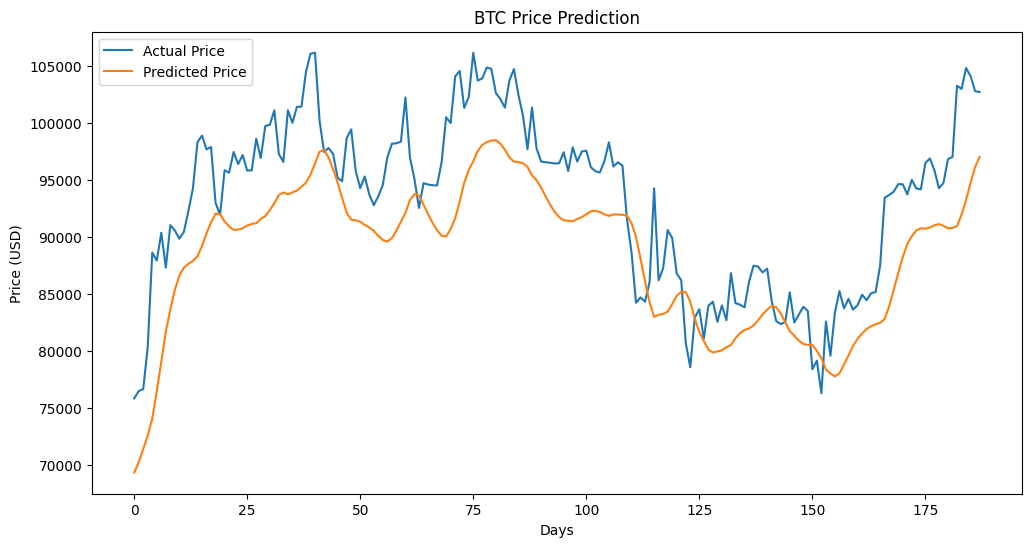

In [9]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras ccxt

import ccxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 1. 데이터 수집 (KuCoin API)
def fetch_crypto_data(symbol='BTC/USDT', timeframe='1d', limit=1000):
    exchange = ccxt.kucoin()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# 2. 데이터 전처리
def prepare_data(data, look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    return np.array(X), np.array(y), scaler

# 3. LSTM 모델 구축
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 4. 내일 주가 예측 함수
def predict_tomorrow_price(model, data, scaler, look_back=60):
    last_sequence = data['close'][-look_back:].values
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))
    X_test = np.array([last_sequence_scaled.reshape(-1)])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_scaled = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_scaled)
    return predicted_price[0][0]

# 메인 실행
if __name__ == "__main__":
    # 데이터 로드
    btc_data = fetch_crypto_data()

    # 데이터 준비
    X, y, scaler = prepare_data(btc_data)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # 모델 훈련 (80% 데이터 사용)
    split = int(0.8 * len(X))
    model = build_lstm_model((X.shape[1], 1))
    model.fit(X[:split], y[:split], epochs=50, batch_size=32, verbose=1)

    # 내일 주가 예측
    tomorrow_price = predict_tomorrow_price(model, btc_data, scaler)
    print(f"예측된 내일 BTC/USDT 종가: ${tomorrow_price:.2f}")

    # 실제 vs 예측 그래프
    predicted = model.predict(X[split:])
    predicted = scaler.inverse_transform(predicted)
    real = scaler.inverse_transform(y[split:].reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(real, label='Actual Price')
    plt.plot(predicted, label='Predicted Price')
    plt.title('BTC Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()